In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import nltk
import pickle
from nltk.stem import WordNetLemmatizer

from yellowbrick.text.freqdist import FreqDistVisualizer 

%matplotlib inline

In [2]:
# dataset is taken from Kaggle website
df_train = pd.read_csv('./dataset/train.csv')

# Note: this df does not have the target column
df_test = pd.read_csv('./dataset/test.csv')

In [3]:
# train data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.shape

(7613, 5)

In [5]:
# test data . Note: it does not have target column and just can be used for testing
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('missing values of the keyword column: {}/{} ({}%)'.
      format(df_train.keyword.isna().sum(),len(df_train),
             round((df_train.keyword.isna().sum() / len(df_train)) * 100,2)))

print('missing values of the location column: {}/{} ({}%)'.
      format(df_train.location.isna().sum(), len(df_train),
             round((df_train.location.isna().sum() / len(df_train)) * 100,2)))

missing values of the keyword column: 61/7613 (0.8%)
missing values of the location column: 2533/7613 (33.27%)


In [7]:
# the number of classes are almost balanced. So, we do not need to balance them.
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

we are going to drop the columns which have missing values as well as ID. 
ID does not add any value to the model that we are about to create.

In [8]:
df_train.drop(['id','location', 'keyword'], axis=1, inplace=True)

In [9]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


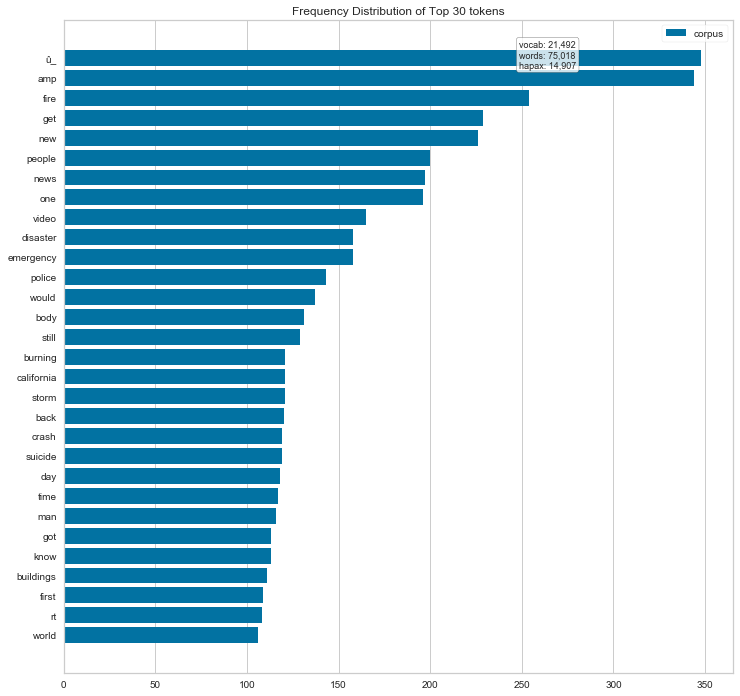

In [10]:
# Find the document term frequency matrix
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['http','https', 'co', 'via', 'us','like']
stopwords.extend(newStopWords)

vect = CountVectorizer(stop_words=stopwords)
X = vect.fit_transform(df_train['text'])

# Get all features (tokens)
features = vect.get_feature_names()

# we can use yellowbrick package for visualization of top 30 tokens
fig, ax = plt.subplots(figsize=(12, 12))
visualizer = FreqDistVisualizer(features=features, n=30)
visualizer.fit(X)
visualizer.poof()

In [11]:
documents = []

stemmer = WordNetLemmatizer()

for i in range(0, len(df_train)):
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(df_train.loc[i,'text']))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to lowercase
    document = document.lower()
    
    # lemmatization 
    # In lemmatization, we can convert the word into the root form of the word. 
    # for exampel, "houses" is converted into "house".
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [12]:
len(documents)

7613

In [26]:
df_train[40:50]

,text,target
40,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
41,on the outside you're ablaze and alive\nbut yo...,0
42,Had an awesome time visiting the CFC head offi...,0
43,SOOOO PUMPED FOR ABLAZE ???? @southridgelife,0
44,I wanted to set Chicago ablaze with my preachi...,0
45,I gained 3 followers in the last week. You? Kn...,0
46,How the West was burned: Thousands of wildfire...,1
47,Building the perfect tracklist to life leave t...,0
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
49,First night with retainers in. It's quite weir...,0


In [25]:
# print 10 rows
documents[40:50]

['check these out http co roi2nsmejj http co 3tj8zjin21 http co yduixefipe http co lxtjc87kls nsfw',
 'on the outside you re ablaze and alive but you re dead inside',
 'had an awesome time visiting the cfc head office the ancop site and ablaze thanks to tita vida for taking care of u',
 'soooo pumped for ablaze southridgelife',
 'i wanted to set chicago ablaze with my preaching but not my hotel http co o9qknbfofx',
 'i gained 3 follower in the last week you know your stats and grow with http co tiyulif5c6',
 'how the west wa burned thousand of wildfire ablaze in california alone http co vl5tbr3wbr',
 'building the perfect tracklist to life leave the street ablaze',
 'check these out http co roi2nsmejj http co 3tj8zjin21 http co yduixefipe http co lxtjc87kls nsfw',
 'first night with retainer in it quite weird better get used to it have to wear them every single night for the next year at least']

## Converting Text to Numbers

Machines, unlike humans, cannot understand the raw text. Machines can only see numbers. Particularly, statistical techniques such as machine learning can only deal with numbers. Therefore, we need to convert our text into numbers.

<ul>   
   <li><b>max_features:</b> Build a vocabulary that only consider the top max_features ordered by term frequency across the corpus</li>
    <li><b>max_df:</b> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.</li>
    </ul>

In [29]:
vectorizer = CountVectorizer(max_features=10000,
                             analyzer='word',
                             max_df=.60,
                             stop_words=stopwords)

X = vectorizer.fit_transform(documents).toarray()

In [15]:
tfidfconverter = TfidfTransformer()

X = tfidfconverter.fit_transform(X).toarray()
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

In [16]:
rfc = RandomForestClassifier(n_estimators=800, 
                             random_state=42, 
                             max_features='auto')

rfc.fit(X_train, y_train)

# predict for testing data
y_pred_test = rfc.predict(X_test)

# predict for training data
y_pred_train = rfc.predict(X_train)

In [17]:
# test
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

0.7972854640980735
[[1172  166]
 [ 297  649]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1338
           1       0.80      0.69      0.74       946

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284



In [18]:
# train
print(accuracy_score(y_train, y_pred_train))
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

0.9855507599924939
[[2982   22]
 [  55 2270]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3004
           1       0.99      0.98      0.98      2325

   micro avg       0.99      0.99      0.99      5329
   macro avg       0.99      0.98      0.99      5329
weighted avg       0.99      0.99      0.99      5329



### Save the Model

In [19]:
#The wb indicates that the file is opened for writing in binary mode
with open('text_classifier', 'wb') as picklefile:
    pickle.dump(rfc,picklefile)

### Load the Model

In [20]:
#The rb indicates that the file is opened for reading in binary mode
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

### Make prediction based on the Loaded model

In [21]:
y_pred_test_2 = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_2))
print(classification_report(y_test, y_pred_test_2))
print(accuracy_score(y_test, y_pred_test_2)) 

[[1172  166]
 [ 297  649]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1338
           1       0.80      0.69      0.74       946

   micro avg       0.80      0.80      0.80      2284
   macro avg       0.80      0.78      0.79      2284
weighted avg       0.80      0.80      0.79      2284

0.7972854640980735
